In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import product
from perlin_numpy import generate_perlin_noise_2d
from scipy.integrate import odeint
from scipy.interpolate import griddata
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [2]:
np.random.seed(0)

obj = "gaussian"

m = 10
n = 2000

percentile = 50

iterations = 10

laplace_alpha = 0

In [3]:
gaussian = lambda X, Y, Z: np.exp(-(X**2 + Y**2 + Z**2) / 2) / np.sqrt(2 * np.pi)**3
helicalvalley = lambda X, Y, Z: -(100 * ((Z - 10 * np.arctan2(Y, X) / 2 / np.pi)**2 + (np.sqrt(X**2 + Y**2) - 1)**2) + Z**2)
logarithmic = lambda X, Y, Z: X**2 * np.log((X - Y + Z)**2 + 1)

objectives = {
    "gaussian": {
        "func": gaussian,
        "bounds": [(-1, 1)] * 3
    },
    "helicalvalley": {
        "func": helicalvalley,
        "bounds": [(-5, 5)] * 3
    },
    "logarithmic": {
        "func": logarithmic,
        "bounds": [(1, 2)] * 3
    }
}

In [4]:
obj = list(objectives.keys())[-1] if obj is None else obj

xyz_range = objectives[obj]["bounds"]

X = np.arange(*xyz_range[0], ((xyz_range[0][1] - xyz_range[0][0]) / 100))
Y = np.arange(*xyz_range[1], ((xyz_range[1][1] - xyz_range[1][0]) / 100))
Z = np.arange(*xyz_range[2], ((xyz_range[2][1] - xyz_range[2][0]) / 100))

X, Y, Z = np.meshgrid(X, Y, Z)

F = objectives[obj]["func"](X, Y, Z)

f_range = (np.floor(np.min(F)) - 1, np.ceil(np.max(F)) + 1)

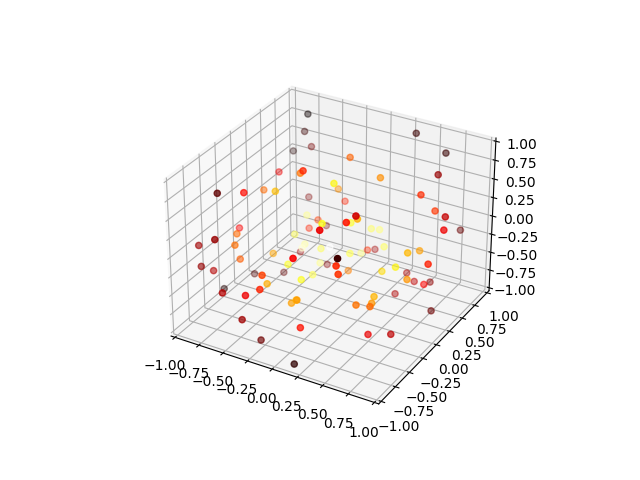

In [5]:
%matplotlib widget

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

i = np.random.randint(0, 100, 100)
j = np.random.randint(0, 100, 100)
k = np.random.randint(0, 100, 100)

ax.scatter(X[0, i, 0], Y[j, 0, 0], Z[0, 0, k], c=F[j, i, k], cmap="hot")

ax.set_xlim(*xyz_range[0])
ax.set_ylim(*xyz_range[1])
ax.set_zlim(*xyz_range[2])

plt.savefig("baseline.png")
plt.show()

In [6]:
ran_err = lambda n, x: np.random.normal(0, x, n)
sys_err = lambda n, z: np.random.normal(2, 0.05, n)

In [7]:
df = pd.DataFrame(np.random.randint(100, size=(m, 3)), columns=["i", "j", "k"])

df["x"] = X[0, df["i"], 0]
df["y"] = Y[df["j"], 0, 0]
df["z"] = Z[0, 0, df["k"]]

df["f"] = F[df["j"], df["i"], df["k"]] + ran_err(m, 0.05)

for idx in range(1, iterations + 1):
    krnl = RBF(length_scale=1)
    model = GaussianProcessRegressor(kernel=krnl, normalize_y=False, random_state=3, alpha=0.001)

    tmp_df = pd.DataFrame(np.random.randint(100, size=(n, 3)), columns=["i", "j", "k"])

    tmp_df["x"] = X[0, tmp_df["i"], 0]
    tmp_df["y"] = Y[tmp_df["j"], 0, 0]
    tmp_df["z"] = Z[0, 0, tmp_df["k"]]

    tmp_df["f"] = F[tmp_df["j"], tmp_df["i"], tmp_df["k"]] + ran_err(n, 0.05) + sys_err(n, F[tmp_df["j"], tmp_df["i"], tmp_df["k"]])

    model.fit(tmp_df[["x", "y", "z"]], tmp_df["f"])

    pred = model.predict(tmp_df[["x", "y", "z"]])

    f = griddata((tmp_df["x"], tmp_df["y"], tmp_df["z"]), pred, (X, Y, Z), method="linear", fill_value=f_range[0])

    tmp_df = pd.DataFrame(list(product(range(100), range(100), range(100))), columns=["i", "j", "k"])

    tmp_df["x"] = X[0, tmp_df["i"], 0]
    tmp_df["y"] = Y[tmp_df["j"], 0, 0]
    tmp_df["z"] = Z[0, 0, tmp_df["k"]]

    tmp_df["f"] = F[tmp_df["j"], tmp_df["i"], tmp_df["k"]] + ran_err(100**3, 0.05)

    mag = f[tmp_df["j"], tmp_df["i"], tmp_df["k"]]

    p = mag - f.min() + laplace_alpha

    p = np.where(p > np.percentile(p, percentile), p, 0)

    p /= p.sum()

    tmp_df = tmp_df.loc[np.random.choice(tmp_df.index, size=m, p=p, replace=False)]

    df = pd.concat([df, tmp_df], ignore_index=True)

krnl = RBF(length_scale=1)
model = GaussianProcessRegressor(kernel=krnl, normalize_y=False, random_state=3, alpha=0.001)

model.fit(df[["x", "y", "z"]], df["f"])

c:\Program Files\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=0.001, kernel=RBF(length_scale=1),
                         random_state=3)

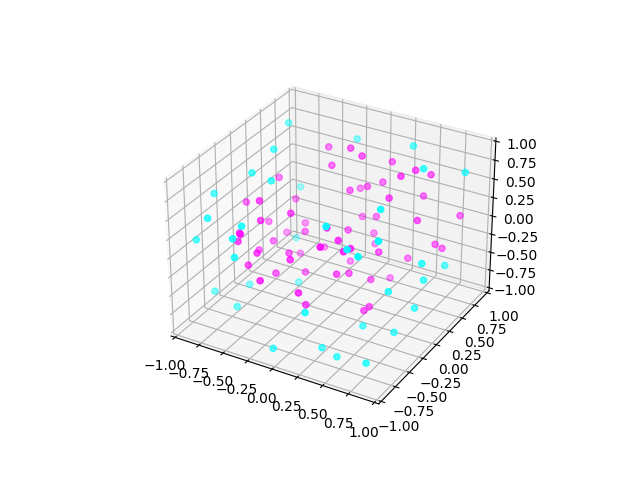

In [8]:
%matplotlib widget

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

pred = model.predict(df[["x", "y", "z"]])

f = griddata((df["x"], df["y"], df["z"]), pred, (X, Y, Z), method="linear", fill_value=(f_range[0] + 1))

i = np.random.randint(0, 100, 100)
j = np.random.randint(0, 100, 100)
k = np.random.randint(0, 100, 100)

ax.scatter(X[0, i, 0], Y[j, 0, 0], Z[0, 0, k], c=f[j, i, k], cmap="cool")

ax.set_xlim(*xyz_range[0])
ax.set_ylim(*xyz_range[1])
ax.set_zlim(*xyz_range[2])

plt.savefig("generated.png")
plt.show()

Predicted maximum: 0.035083806802731786 at (4, 65, 75)
Actual maximum: 0.06349363593424098 at (50, 50, 50)
RMSE: 0.010332588855820562


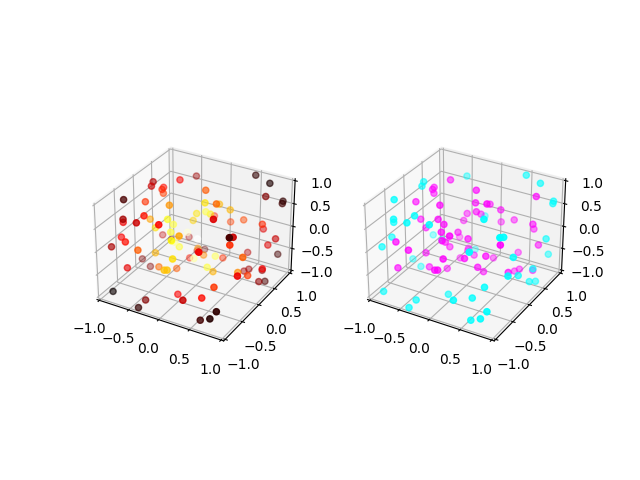

In [9]:
%matplotlib widget

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"})

print("Predicted maximum:", F[np.unravel_index(f.argmax(), f.shape)], "at", np.unravel_index(f.argmax(), f.shape))
print("Actual maximum:", F.max(), "at", np.unravel_index(F.argmax(), F.shape))

df = pd.DataFrame(list(product(range(100), range(100), range(100))), columns=["i", "j", "k"])

df["x"] = X[0, df["i"], 0]
df["y"] = Y[df["j"], 0, 0]
df["z"] = Z[0, 0, df["k"]]

df["f"] = F[df["j"], df["i"], df["k"]]

pred = model.predict(df[["x", "y", "z"]])

sum = np.sum((pred - df["f"])**2)
rmse = np.sqrt(sum / len(df["f"]))

print("RMSE:", rmse)

i = np.random.randint(0, 100, 100)
j = np.random.randint(0, 100, 100)
k = np.random.randint(0, 100, 100)

axs[0].scatter(X[0, i, 0], Y[j, 0, 0], Z[0, 0, k], c=F[j, i, k], cmap="hot")
axs[1].scatter(X[0, i, 0], Y[j, 0, 0], Z[0, 0, k], c=f[j, i, k], cmap="cool")

axs[0].set_xlim(*xyz_range[0])
axs[0].set_ylim(*xyz_range[1])
axs[0].set_zlim(*xyz_range[2])
axs[1].set_xlim(*xyz_range[0])
axs[1].set_ylim(*xyz_range[1])
axs[1].set_zlim(*xyz_range[2])

plt.show()